<a href="https://colab.research.google.com/github/Jasonshen5168/DIP-Noise2Noise-/blob/main/Deep_Image_Prior_F16_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
import os
import csv
from skimage.metrics import peak_signal_noise_ratio as psnr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
input_image_path = '/content/drive/MyDrive/NCHU博士班/結構化機器學習模型及其應用/Project/F16_GT.png'
save_dir = '/content/drive/MyDrive/NCHU博士班/結構化機器學習模型及其應用/Project/generated_images_paper_F16'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
input_image = Image.open(input_image_path).convert('RGB')
input_image = np.array(input_image) / 255.0
input_image = np.expand_dims(input_image, axis=0)
print(f"Input image shape: {input_image.shape}")

Input image shape: (1, 512, 512, 3)


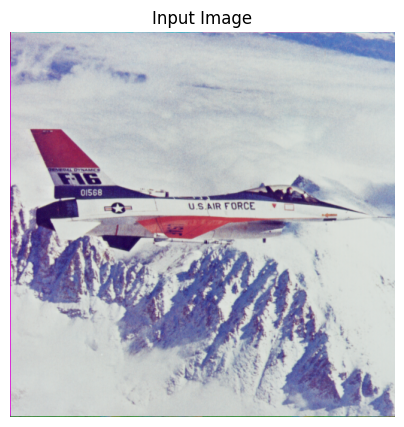

In [ ]:
plt.figure(figsize=(5, 5))
plt.title('Input Image')
plt.imshow(input_image[0])
plt.axis('off')
plt.show()

Input image shape: (1, 512, 512, 3)
Noisy image shape: (1, 512, 512, 3)


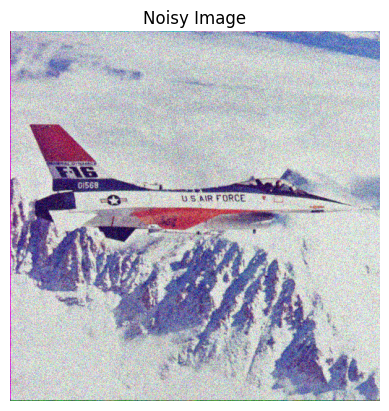

In [ ]:
noise_factor = 0.1
noisy_image = input_image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=input_image.shape)
noisy_image = np.clip(noisy_image, 0.0, 1.0)

print(f"Input image shape: {input_image.shape}")
print(f"Noisy image shape: {noisy_image.shape}")

plt.imshow(noisy_image[0])
plt.title('Noisy Image')
plt.axis('off')
plt.savefig(os.path.join(save_dir, 'noisy_image.png'))
plt.show()

In [ ]:
def deep_image_prior_model(input_shape):
  inputs = tf.keras.layers.Input(shape=input_shape)

  def conv_block(x, num_filters, kernel_size=3, strides=1, activation='relu'):
      x = tf.keras.layers.Conv2D(num_filters, kernel_size, strides=strides, padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation(activation)(x)
      return x

  def upsampling_block(x, num_filters, kernel_size=3, strides=1, activation='relu'):
      x = tf.keras.layers.UpSampling2D()(x)
      x = tf.keras.layers.Conv2D(num_filters, kernel_size, strides=strides, padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Activation(activation)(x)
      return x

  x = conv_block(inputs, 128)
  x = conv_block(x, 128)
  skip1 = x
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)

  x = conv_block(x, 128)
  x = conv_block(x, 128)
  skip2 = x
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)

  x = conv_block(x, 128)
  x = conv_block(x, 128)
  skip3 = x
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)

  x = upsampling_block(x, 128)
  x = tf.image.resize(x, tf.shape(skip3)[1:3])  # 调整形状匹配
  x = tf.keras.layers.Concatenate()([x, skip3])
  x = conv_block(x, 128)
  x = conv_block(x, 128)

  x = upsampling_block(x, 128)
  x = tf.image.resize(x, tf.shape(skip2)[1:3])  # 调整形状匹配
  x = tf.keras.layers.Concatenate()([x, skip2])
  x = conv_block(x, 128)
  x = conv_block(x, 128)

  x = upsampling_block(x, 128)
  x = tf.image.resize(x, tf.shape(skip1)[1:3])  # 调整形状匹配
  x = tf.keras.layers.Concatenate()([x, skip1])
  x = conv_block(x, 128)
  x = conv_block(x, 128)

  outputs = tf.keras.layers.Conv2D(3, (1, 1), padding='same', activation='sigmoid')(x)

  return tf.keras.Model(inputs, outputs)

In [ ]:
generator = deep_image_prior_model((512, 512, 32))

In [ ]:
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
checkpoint_dir = os.path.join(save_dir, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, generator=generator)

In [ ]:
def save_checkpoint(epoch):
  checkpoint.save(file_prefix=checkpoint_prefix)
  print(f'Checkpoint saved at epoch {epoch}')

def load_checkpoint():
  latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
  if latest_checkpoint:
      checkpoint.restore(latest_checkpoint)
      print(f'Checkpoint restored from {latest_checkpoint}')
      return int(latest_checkpoint.split('-')[-1])
  return 1

In [ ]:
@tf.function
def train_step(noise_image, train_image):
  with tf.GradientTape() as tape:
      generated_image = generator(noise_image, training=True)
      generated_image = tf.image.resize(generated_image, train_image.shape[1:3])
      loss = loss_function(train_image, generated_image)
  gradients = tape.gradient(loss, generator.trainable_variables)
  optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
  return loss, generated_image

In [ ]:
noise_input = np.random.normal(0, 1/10, (1, 512, 512, 32)).astype(np.float32)

In [ ]:
total_epochs = 1000
save_interval = 1
start_epoch = load_checkpoint()

In [ ]:
losses = []
for epoch in range(start_epoch, total_epochs + 1):
  loss, generated_image = train_step(noise_input, input_image)
  losses.append([epoch, loss.numpy()])

  # if epoch % save_interval == 0 or epoch == total_epochs:
  # save_checkpoint(epoch)
  image_array = (generated_image.numpy()[0] * 255).astype(np.uint8)
  image = Image.fromarray(image_array)
  image_path = os.path.join(save_dir, f'generated_image_epoch_{epoch}.png')
  image.save(image_path)
  print(f'Epoch {epoch}, Loss: {loss.numpy()}, Image saved to {image_path}')


Epoch 1, Loss: 0.16241556406021118, Image saved to /content/drive/MyDrive/NCHU博士班/結構化機器學習模型及其應用/Project/generated_images_paper_F16/generated_image_epoch_1.png
Epoch 2, Loss: 0.14629818499088287, Image saved to /content/drive/MyDrive/NCHU博士班/結構化機器學習模型及其應用/Project/generated_images_paper_F16/generated_image_epoch_2.png
Epoch 3, Loss: 0.07218621671199799, Image saved to /content/drive/MyDrive/NCHU博士班/結構化機器學習模型及其應用/Project/generated_images_paper_F16/generated_image_epoch_3.png
Epoch 4, Loss: 0.042917825281620026, Image saved to /content/drive/MyDrive/NCHU博士班/結構化機器學習模型及其應用/Project/generated_images_paper_F16/generated_image_epoch_4.png
Epoch 5, Loss: 0.03351530060172081, Image saved to /content/drive/MyDrive/NCHU博士班/結構化機器學習模型及其應用/Project/generated_images_paper_F16/generated_image_epoch_5.png
Epoch 6, Loss: 0.029017530381679535, Image saved to /content/drive/MyDrive/NCHU博士班/結構化機器學習模型及其應用/Project/generated_images_paper_F16/generated_image_epoch_6.png
Epoch 7, Loss: 0.02456655539572239, Image sa

In [ ]:
loss_file_path = os.path.join(save_dir, 'losses.csv')
with open(loss_file_path, 'w', newline='') as loss_file:
  writer = csv.writer(loss_file)
  writer.writerow(['Epoch', 'Loss'])
  writer.writerows(losses)

print(f'All losses saved to {loss_file_path}')

In [ ]:
epochs = [epoch_loss[0] for epoch_loss in losses]
loss_values = [epoch_loss[1] for epoch_loss in losses]

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'loss_vs_epoch.png'))  # 保存图像
plt.show()

In [ ]:
loss_file_path = os.path.join(save_dir, 'losses.csv')
with open(loss_file_path, 'w', newline='') as loss_file:
  writer = csv.writer(loss_file)
  writer.writerow(['Epoch', 'Loss'])  # 写入标题行
  writer.writerows(losses)

print(f'All losses saved to {loss_file_path}')

All losses saved to /content/drive/MyDrive/NCHU博士班/結構化機器學習模型及其應用/Project/generated_images_paper_F16/losses.csv


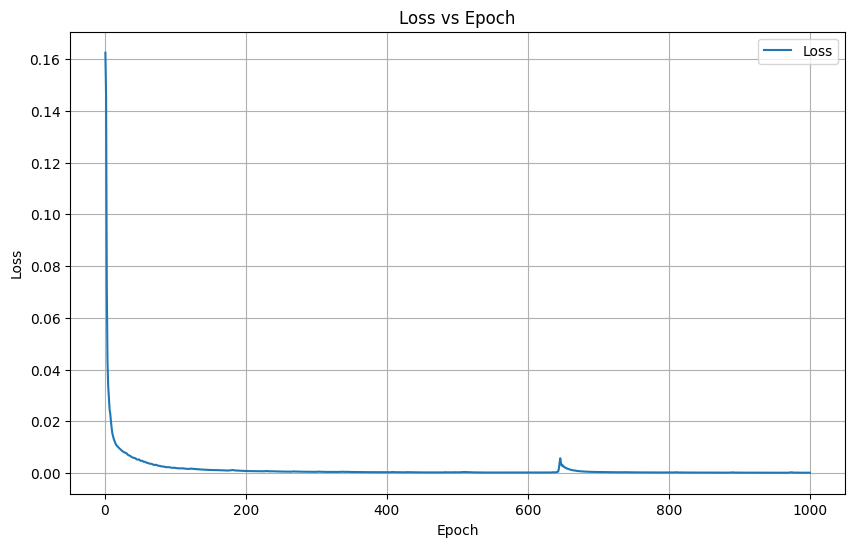

In [ ]:
epochs = [epoch_loss[0] for epoch_loss in losses]
loss_values = [epoch_loss[1] for epoch_loss in losses]

# 绘制损失值随epoch变化的图
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'loss_vs_epoch.png'))  # 保存图像
plt.show()